In [80]:
import os
from sagemaker import get_execution_role
from dotenv import load_dotenv
from load_data import load_data
from split_data import split_data
import importlib
from save_model_to_s3 import save_model_to_s3
from deploy_model_endpoint import deploy_model
from finalize_and_save_model import finalize_and_save_model
from delete_sagemaker_endpoint import delete_sagemaker_endpoint
from ydata_profiling import ProfileReport
import shap
import pandas as pd

In [81]:
# Variables Setup Stage
load_dotenv(".env")
role = get_execution_role()

# Env variables
data_location_s3 = os.getenv("data_location_s3")
algorithm_choice = os.getenv("algorithm_choice")
target = os.getenv("target")
endpoint_name = os.getenv("endpoint_name")
model_name = os.getenv("model_name")
# data_location = "s3://{}".format(data_location_s3)
data_location = data_location_s3
instance_type = os.getenv("instance_type")
model_instance_count = int(os.getenv("model_instance_count"))
image_uri = os.getenv("ecr_repo_uri")
tuning_metric = os.getenv("tuning_metric")

print(
    data_location_s3,
    algorithm_choice,
    target,
    endpoint_name,
    model_name,
    data_location,
    instance_type,
    image_uri,
    tuning_metric,
)

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/lanre.bakare/Library/Application Support/sagemaker/config.yaml
ethan_data.csv classification y classification-proba-endpoint banking-classification ethan_data.csv ml.m4.xlarge mlops-classification-repo AUC


In [82]:
df = load_data(data_location)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [83]:
df = df.drop(columns=["poutcome"])

In [84]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'y' column to numerical values
df["y"] = label_encoder.fit_transform(df["y"])
df["month"] = label_encoder.fit_transform(df["month"])
df["education"] = label_encoder.fit_transform(df["education"])

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

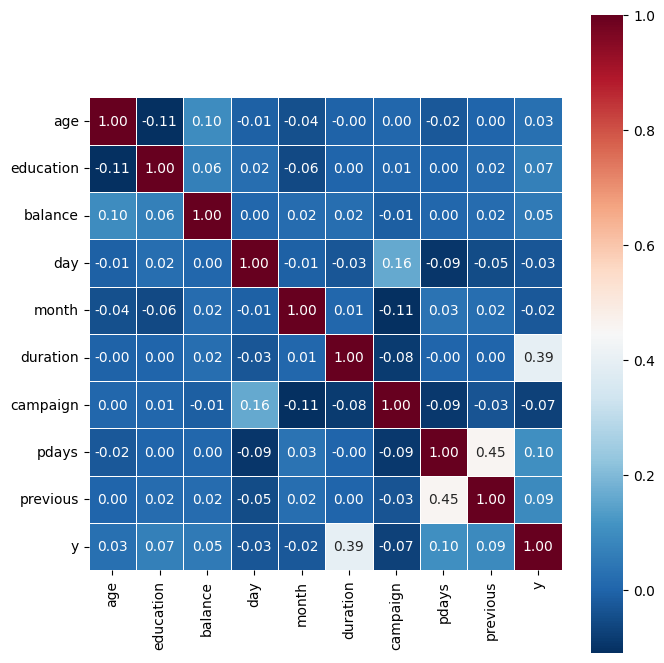

In [86]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(
    df._get_numeric_data().astype(float).corr(),
    square=True,
    cmap="RdBu_r",
    linewidths=0.5,
    annot=True,
    fmt=".2f",
).figure.tight_layout()
plt.show()

# sns.heatmap(df.corr())

In [87]:
cat_features = df.select_dtypes(include=["object", "bool"]).columns.values
print(cat_features)

['job' 'marital' 'default' 'housing' 'loan' 'contact']


In [88]:
# Apply one-hot encoding to categorical columns
data_encoded = pd.get_dummies(
    df, columns=["job", "marital", "contact", "default", "housing", "loan"]
)

In [89]:
pd.set_option("display.max_columns", None)

In [90]:
data_encoded.head()

,age,education,balance,day,month,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,contact_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes
0,58,2,2143,5,8,261,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,1,0
1,44,1,29,5,8,151,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,1,0
2,33,1,2,5,8,76,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,1
3,47,3,1506,5,8,92,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,1,0
4,33,3,1,5,8,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0


In [91]:
# Drop columns related to the 'unknown' category
unknown_columns = ["job_unknown", "contact_unknown"]

data_encoded.drop(unknown_columns, axis=1, inplace=True)

In [92]:
data_encoded.head()

,age,education,balance,day,month,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes
0,58,2,2143,5,8,261,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0
1,44,1,29,5,8,151,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0
2,33,1,2,5,8,76,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1
3,47,3,1506,5,8,92,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0
4,33,3,1,5,8,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0


In [93]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   age                45211 non-null  int64
 1   education          45211 non-null  int64
 2   balance            45211 non-null  int64
 3   day                45211 non-null  int64
 4   month              45211 non-null  int64
 5   duration           45211 non-null  int64
 6   campaign           45211 non-null  int64
 7   pdays              45211 non-null  int64
 8   previous           45211 non-null  int64
 9   y                  45211 non-null  int64
 10  job_admin.         45211 non-null  uint8
 11  job_blue-collar    45211 non-null  uint8
 12  job_entrepreneur   45211 non-null  uint8
 13  job_housemaid      45211 non-null  uint8
 14  job_management     45211 non-null  uint8
 15  job_retired        45211 non-null  uint8
 16  job_self-employed  45211 non-null  uint8
 17  job_services

In [94]:
data_encoded.shape

(45211, 32)

In [95]:
data_encoded.corr()

,age,education,balance,day,month,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes
age,1.000000,-0.106807,0.097783,-0.009120,-0.042357,-0.004648,0.004760,-0.023758,0.001288,0.025155,-0.055717,-0.044002,0.021792,0.086650,-0.023571,0.447378,-0.008093,-0.065780,-0.197302,-0.068632,0.000412,0.164674,0.286257,-0.427817,-0.068375,0.170349,0.017879,-0.017879,0.185513,-0.185513,0.015655,-0.015655
education,-0.106807,1.000000,0.064514,0.022671,-0.057304,0.001935,0.006255,0.000052,0.017570,0.066241,-0.042508,-0.351744,0.053173,-0.116376,0.426379,-0.094904,0.068619,-0.079529,0.061019,0.046353,-0.035868,-0.010523,-0.121185,0.139162,0.115600,-0.044168,0.010718,-0.010718,0.090790,-0.090790,0.048574,-0.048574
balance,0.097783,0.064514,1.000000,0.004503,0.019777,0.021560,-0.014578,0.003435,0.016674,0.052838,-0.026726,-0.048757,0.009642,0.001661,0.067797,0.046900,0.017850,-0.038151,0.001233,-0.016183,0.009023,-0.021732,0.025708,-0.012537,0.015880,0.037999,0.066745,-0.066745,0.068768,-0.068768,0.084350,-0.084350
day,-0.009120,0.022671,0.004503,1.000000,-0.006028,-0.030206,0.162490,-0.093044,-0.051710,-0.028348,-0.010455,-0.022898,-0.002312,0.003955,0.019021,-0.010123,0.005062,-0.006531,-0.015894,0.032517,-0.006382,-0.000433,0.007102,-0.007412,0.020186,0.023652,-0.009424,0.009424,0.027982,-0.027982,-0.011370,0.011370
month,-0.042357,-0.057304,0.019777,-0.006028,1.000000,0.006314,-0.110031,0.033065,0.022727,-0.024471,0.037639,0.090080,0.037585,-0.036506,-0.057542,-0.024422,0.004093,0.038820,-0.001372,-0.083168,-0.004462,0.026538,-0.025927,0.009369,-0.338259,-0.004616,-0.011486,0.011486,-0.271481,0.271481,-0.022145,0.022145
duration,-0.004648,0.001935,0.021560,-0.030206,0.006314,1.000000,-0.084570,-0.001565,0.001203,0.394521,-0.015722,0.009637,-0.001327,-0.008046,-0.008323,0.026032,0.007383,0.001427,-0.006504,-0.009176,0.020322,0.006100,-0.022683,0.020328,0.025543,-0.023201,0.010021,-0.010021,-0.005075,0.005075,0.012412,-0.012412
campaign,0.004760,0.006255,-0.014578,0.162490,-0.110031,-0.084570,1.000000,-0.088628,-0.032855,-0.073172,-0.021868,0.008986,0.002128,0.003097,0.016686,-0.030913,0.005479,-0.004671,-0.021813,0.020739,-0.018448,-0.015484,0.031371,-0.023120,-0.032271,0.053895,-0.016822,0.016822,0.023599,-0.023599,-0.009980,0.009980
pdays,-0.023758,0.000052,0.003435,-0.093044,0.033065,-0.001565,-0.088628,1.000000,0.454820,0.103621,0.027497,0.020063,-0.014203,-0.031350,-0.007871,-0.006315,-0.010356,0.005710,0.024486,-0.013478,-0.010411,0.002897,-0.027600,0.027943,0.225996,0.016006,0.029979,-0.029979,-0.124178,0.124178,0.022754,-0.022754
previous,0.001288,0.017570,0.016674,-0.051710,0.022727,0.001203,-0.032855,0.454820,1.000000,0.093236,0.014245,-0.017095,-0.008181,-0.015204,0.019579,0.005818,-0.002371,-0.010926,0.023556,-0.001123,-0.008504,-0.004534,-0.012691,0.017006,0.131717,0.028097,0.018329,-0.018329,-0.037076,0.037076,0.011043,-0.011043
y,0.025155,0.066241,0.052838,-0.028348,-0.024471,0.394521,-0.073172,0.103621,0.093236,1.000000,0.005637,-0.072083,-0.019662,-0.015195,0.032919,0.079245,0.000855,-0.027864,0.076897,-0.008970,0.020390,0.002772,-0.060260,0.063526,0.135873,0.014042,0.022419,-0.022419,0.139173,-0.139173,0.068185,-0.068185


In [96]:
data_encoded = data_encoded.drop(columns=["day", "month"])

In [97]:
X = data_encoded.drop(columns=["y"])
y = data_encoded["y"]

In [98]:
print(X.shape, y.shape)

(45211, 29) (45211,)


In [99]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=123)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [100]:
# Concatenate the resampled 'X' and 'y' to form a new DataFrame
resampled_data = pd.concat([X_resampled, pd.Series(y_resampled, name="y")], axis=1)

In [101]:
# Calculate the count of 'yes' and 'no' in the 'y' column
yes_count = (resampled_data["y"] == 1).sum()
no_count = (resampled_data["y"] == 0).sum()

# Calculate the total count of values in the 'y' column
total_count = len(resampled_data)

# Calculate the percentage of 'yes' and 'no'
percentage_yes = (yes_count / total_count) * 100
percentage_no = (no_count / total_count) * 100
print("After sampling")
print("Percentage of 'yes' in 'y':", percentage_yes)
print("Percentage of 'no' in 'y':", percentage_no)

After sampling
Percentage of 'yes' in 'y': 50.0
Percentage of 'no' in 'y': 50.0


In [102]:
resampled_data.to_csv("cleaned_ethan_data.csv", index=False)